# **Predicción de supervivencia post-transplante de células HCT**

In [1]:
# === 1. Importación de librerías necesarias ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold

In [2]:
# === 2. Cargar datos ===
df = pd.read_csv("data.csv")
print('Tamaño del dataset:', df.shape)
print('Información general del dataset:')
df.info()

Tamaño del dataset: (28800, 60)
Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26

In [3]:
# === 3.Eliminar columnas con demasiados valores nulos o irrelevantes ===
print('Valores nulos del dataset por columnas:')

missing_values = df.isnull().sum()
missing_values_percentage = (missing_values / len(df)) * 100
missing_values_percentage

print('Mayor porcentaje de valores nulos:', missing_values_percentage.max())

#Eliminamos aquellas columnas que tienen más de un 30% de valores nulos
#Eliminamos las columnas 'ID' y 'efs_time'
missing = df.isnull().mean() * 100
cols_to_drop = missing[missing > 30].index.tolist()
df = df.drop(columns=cols_to_drop)

#Eliminamos la columna ID
df = df.drop(columns=[col for col in ['ID'] if col in df.columns])
df.shape

Valores nulos del dataset por columnas:
Mayor porcentaje de valores nulos: 65.95833333333333


(28800, 54)

In [4]:
# === 4.Separar la variable objetivo y predictoras ===

# Variables objetivo
time_col = 'efs_time'
event_col = 'efs'

df_target = df[[time_col, event_col]]
df_input = df.drop(columns=[time_col, event_col])

In [5]:
# === 5. Separar en train/test ANTES de procesar ===
X_train, X_test, y_train, y_test = train_test_split(
    df_input, df_target, test_size=0.2, random_state=42
)

In [6]:
# === 6. Funciones de preprocesamiento (las mismas que para la predicción ) ===

def transformar_variables(df):
    df = df.copy()

   # --- dri_score-- 
    map_dri = {
        'High': 'High', 
        'Intermediate - TED AML case <missing cytogenetics': 'Intermediate',
        'TBD cytogenetics': 'Unknown',
        'Intermediate': 'Intermediate',
        'N/A - non-malignant indication': 'N/A', 
        'Low': 'Low',
        'N/A - pediatric': 'N/A', 
        'High - TED AML case <missing cytogenetics':'High',
        'N/A - disease not classifiable': 'N/A', 
        'Very high': 'High',
        'Missing disease status': 'Unknown', 
        'N/A': 'N/A', 'Unknown':'Unknown'}
    df['dri_score'] = df['dri_score'].replace(map_dri).fillna('Unknown')

    # --- pysch_disturb-- 
    df['psych_disturb'] = df['psych_disturb'].replace({'Not done': 'No'}).fillna('No')

    # --- cyto_score ---
    map_cyto = {
        'Favorable': 'Favorable', 
        'Intermediate': 'Intermediate', 
        'Poor': 'Poor',
        'Normal': 'Intermediate', 
        'Other': 'Intermediate', 
        'TBD': 'Unknown', 
        'Not tested': 'Unknown'}
    df['cyto_score'] = df['cyto_score'].replace(map_cyto).fillna('Unknown')

    # --- diabetes ---
    df['diabetes'] = df['diabetes'].replace({'Not done': 'No'}).fillna('No')
    
    # --- arrhytmia ---
    df['arrhythmia'] = df['arrhythmia'].replace({'Not done': 'No'}).fillna('No')

    # --- tbi_status ---
    df['tbi_status'] = df['tbi_status'].apply(lambda x: 'TBI' if x != 'No TBI' else 'No TBI')

    bin_vars = ['renal_issue', 'pulm_severe', 'hepatic_severe', 'hepatic_mild', 'cardiac',
                'rheum_issue', 'prior_tumor', 'obesity', 'peptic_ulcer', 'pulm_moderate',
                'vent_hist', 'rituximab', 'in_vivo_tcd']
    for col in bin_vars:
        df[col] = df[col].replace({'Not done': 'No'}).fillna('No')

    # --- prim_disease_hct ---
    if 'prim_disease_hct' in df.columns:
        comunes = df['prim_disease_hct'].value_counts()[lambda x: x >= 1000].index
        df['prim_disease_hct'] = df['prim_disease_hct'].apply(lambda x: x if x in comunes else 'Other_disease')

    # --- conditioning_intensity ---
    if 'conditioning_intensity' in df.columns:
        df['conditioning_intensity'] = df['conditioning_intensity'].replace({
            'TBD': 'Unknown', 'No drugs reported': 'Unknown', 'N/A...': 'Unknown'}).fillna('Unknown')

    # --- donor_related ---
    if 'donor_related' in df.columns:
        df['donor_related'] = df['donor_related'].replace({'Multiple donor (non-UCB)': 'Unrelated'})

    # --- gvhd_proph --
    def agrupar_gvhd(valor):
        if pd.isna(valor): return 'Other'
        valor = valor.lower()
        if 'fk' in valor: return 'FK-based'
        elif 'csa' in valor: return 'CSA-based'
        elif 'cyclophosphamide' in valor: return 'Cyclophosphamide-based'
        elif 'tdepletion' in valor: return 'TDEPLETION-based'
        elif 'cdselect' in valor: return 'CDselect-based'
        elif 'mmf' in valor or 'mtx' in valor: return 'MMF/MTX-based'
        elif 'prophylaxis' in valor or 'no agent' in valor: return 'Other'
        else: return 'Other'

    if 'gvhd_proph' in df.columns:
        df['gvhd_proph'] = df['gvhd_proph'].apply(agrupar_gvhd)

    # -- Columnas con registros vacios -- 
    # Imputación para variables numéricas con el valor más repetido
    columnas_hla = ['hla_match_c_high', 'hla_high_res_8', 'hla_high_res_6', 'hla_high_res_10',
                    'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_a_high', 'hla_match_b_high',
                    'hla_match_drb1_high']
    for col in columnas_hla:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode(dropna=True)[0])

    # Imputación para variables numéricas con media entera
    for col in ['donor_age', 'comorbidity_score', 'karnofsky_score']:
        if col in df.columns:
            df[col] = df[col].fillna(int(round(df[col].mean(skipna=True))))

    # Eliminación de variables no informativas o redundantes ---
    columnas_a_eliminar = [
        'hla_low_res_6','hla_match_c_low', 'hla_match_drb1_low',
        'hla_match_dqb1_low','hla_match_b_low','hla_match_a_low',
        'hla_low_res_8','hla_low_res_10'
    ]
    columnas_a_eliminar_existentes = [col for col in columnas_a_eliminar if col in df.columns]
    df = df.drop(columns=columnas_a_eliminar_existentes)
    return df

def transformar_variables2(df):
    var_eliminar = ['hla_match_c_high','hla_high_res_6','hla_high_res_10', 
                    'hla_match_dqb1_high', 'hla_nmdp_6', 'rituximab',
                    'year_hct','hla_match_a_high','donor_age', 'peptic_ulcer',
                    'hla_match_b_high', 'hepatic_mild','hla_match_drb1_high']
    existentes = [col for col in var_eliminar if col in df.columns]
    return df.drop(columns=existentes)

# === Preprocesamiento seguro ===
def codificar_variables(df, encoder=None, fit=True):
    df = df.copy()

    # --- 1. Codificación de variables ordinales ---
    ordinal_mappings = {
        'dri_score': {'Low': 1, 'Intermediate': 2, 'High': 3, 'N/A': 0, 'Unknown': -1},
        'cyto_score': {'Favorable': 1, 'Intermediate': 2, 'Poor': 3, 'Unknown': -1}}
    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # --- 2. Codificación de variables binarias (Yes/No) ---
    bin_cols = [col for col in df.columns
                if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({'Yes', 'No'})]
    for col in bin_cols:
        df[col] = df[col].map({'No': 0, 'Yes': 1})

    # --- 3. Codificación One-Hot de variables categóricas nominales ---
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    cat_cols = [col for col in cat_cols if col not in ordinal_mappings and col not in bin_cols]

    if cat_cols:
        if fit:
            encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
            encoded = encoder.fit_transform(df[cat_cols])
        else:
            encoded = encoder.transform(df[cat_cols])

        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=df.index)
        df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

    return df, encoder

def normalizar_datos(df, scaler=None, fit=True):
    df = df.copy()
    columnas = df.select_dtypes(include='number').columns.tolist()
    if fit:
        scaler = StandardScaler()
        df[columnas] = scaler.fit_transform(df[columnas])
    else:
        df[columnas] = scaler.transform(df[columnas])
    return df, scaler

def procesamiento_datos_entrenamiento(df):
    df = transformar_variables(df)
    df = transformar_variables2(df)
    df, encoder = codificar_variables(df, fit=True)
    df, scaler = normalizar_datos(df, fit=True)
    return df, encoder, scaler

def procesamiento_datos_test(df, encoder, scaler):
    df = transformar_variables(df)
    df = transformar_variables2(df)
    df, _ = codificar_variables(df, encoder=encoder, fit=False)
    df, _ = normalizar_datos(df, scaler=scaler, fit=False)
    return df


In [7]:
# === 7. Aplicar preprocesamiento ===
X_train_proc, encoder, scaler = procesamiento_datos_entrenamiento(X_train)
df_train = pd.concat([y_train.reset_index(drop=True), X_train_proc.reset_index(drop=True)], axis=1)

X_test_proc = procesamiento_datos_test(X_test, encoder, scaler)
df_test = pd.concat([y_test.reset_index(drop=True), X_test_proc.reset_index(drop=True)], axis=1)

test_X = df_test.drop(columns=[time_col, event_col])
test_time = df_test[time_col]
test_event = df_test[event_col]

In [8]:
# === 8. Validación cruzada para elegir penalizer ===
penalizers = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0]
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejores_resultados = []

for pen in penalizers:
    c_indices = []
    
    for train_idx, val_idx in kf.split(df_train):
        train_fold = df_train.iloc[train_idx]
        val_fold = df_train.iloc[val_idx]
        
        model = CoxPHFitter(penalizer=pen)
        model.fit(train_fold, duration_col=time_col, event_col=event_col)
        
        val_X = val_fold.drop(columns=[time_col, event_col])
        val_time = val_fold[time_col]
        val_event = val_fold[event_col]
        
        risk_scores = model.predict_partial_hazard(val_X)
        c_index = concordance_index(val_time, -risk_scores, val_event)
        c_indices.append(c_index)
    
    mean_c_index = np.mean(c_indices)
    mejores_resultados.append((pen, mean_c_index))
    print(f"Penalizer={pen}: C-index promedio (CV) = {mean_c_index:.4f}")

# Elegir el mejor penalizer
mejor_penalizer = max(mejores_resultados, key=lambda x: x[1])[0]
print(f"\n✅ Mejor penalizer según CV: {mejor_penalizer}")


Penalizer=0.001: C-index promedio (CV) = 0.6449
Penalizer=0.01: C-index promedio (CV) = 0.6450
Penalizer=0.05: C-index promedio (CV) = 0.6449
Penalizer=0.1: C-index promedio (CV) = 0.6447
Penalizer=0.5: C-index promedio (CV) = 0.6426
Penalizer=1.0: C-index promedio (CV) = 0.6407

✅ Mejor penalizer según CV: 0.01


<lifelines.CoxPHFitter: fitted with 23040 total observations, 10585 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12455
   partial log-likelihood = -118918.26
         time fit was run = 2025-07-14 21:05:28 UTC

---
                                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                             
dri_score                                             0.09      1.10      0.01            0.07            0.11                1.07                1.12
psych_disturb                                         0.03      1.03      0.01            0.01            0.04                1.01                1.04
cyto_score                                            0.05      1.05      0.01            0.03            0.07                1.03                1.07
diabetes                                              0.03      1.03      0.01            0.02            0.05                1.02                1.05
hla_high_res_8                                       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
arrhythmia                                            0.01      1.01      0.01           -0.01            0.03                0.99                1.03
vent_hist                                             0.02      1.03      0.01            0.01            0.04                1.01                1.04
renal_issue                                          -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
pulm_severe                                           0.06      1.07      0.01            0.05            0.08                1.05                1.08
obesity                                               0.01      1.01      0.01           -0.01            0.03                0.99                1.03
in_vivo_tcd                                          -0.02      0.98      0.01           -0.05           -0.00                0.96                1.00
hepatic_severe                                       -0.05      0.96      0.01           -0.07           -0.02                0.94                0.98
prior_tumor                                           0.01      1.01      0.01           -0.00            0.03                1.00                1.03
age_at_hct                                            0.03      1.03      0.01            0.01            0.05                1.01                1.05
rheum_issue                                          -0.02      0.98      0.01           -0.04           -0.00                0.96                1.00
comorbidity_score                                     0.12      1.13      0.01            0.10            0.14                1.11                1.15
karnofsky_score                                      -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
cardiac                                               0.07      1.07      0.01            0.05            0.08                1.05                1.09
pulm_moderate                                         0.02      1.02      0.01            0.00            0.04                1.00                1.04
tbi_status_TBI                                        0.08      1.08      0.01            0.06            0.10                1.06                1.10
graft_type_Peripheral blood                           0.03      1.03      0.02           -0.00            0.07                1.00                1.07
prim_disease_hct_AML                                  0.00      1.00      0.01           -0.


📊 Resumen del rendimiento predictivo del modelo:
     Conjunto  C-index
Entrenamiento 0.647649
         Test 0.643013


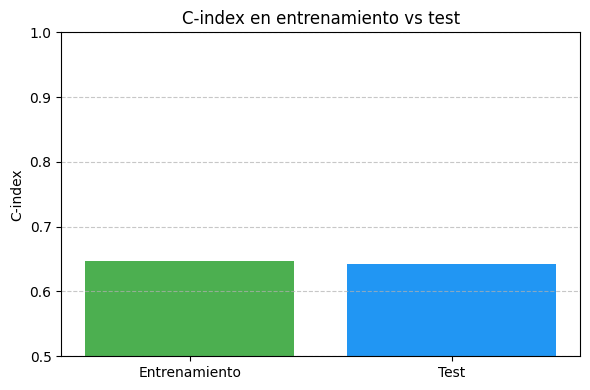

In [9]:
# === 9. Entrenar modelo final con mejor penalizer ===
cph = CoxPHFitter(penalizer=mejor_penalizer)
cph.fit(df_train, duration_col=time_col, event_col=event_col)
cph.print_summary()

# === Evaluar en test ===
risk_train = cph.predict_partial_hazard(df_train.drop(columns = [time_col, event_col]))
risk_test = cph.predict_partial_hazard(test_X)
c_index_train = concordance_index(df_train[time_col], -risk_train, df_train[event_col])
c_index_test = concordance_index(test_time, -risk_test, test_event)
resumen_cindex = pd.DataFrame({'Conjunto': ['Entrenamiento', 'Test'], 'C-index':[c_index_train, c_index_test]})
print("\n\U0001F4CA Resumen del rendimiento predictivo del modelo:")
print(resumen_cindex.to_string(index=False))

# Gráfico de barras comparativo
plt.figure(figsize=(6, 4))
plt.bar(resumen_cindex["Conjunto"], resumen_cindex["C-index"], color=["#4caf50", "#2196f3"])
plt.ylim(0.5, 1)
plt.title("C-index en entrenamiento vs test")
plt.ylabel("C-index")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()




🔪 Estimación automática del punto de inflexión global:

↓ Punto de inflexión global estimado en t = 31.0 meses


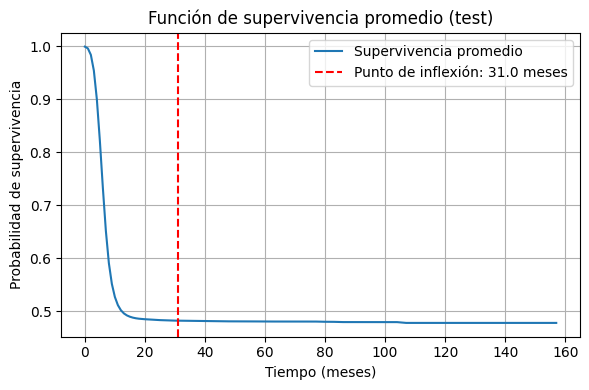

In [10]:
# === Predicción determinista del tiempo al evento ===
# Punto de corte automático global: mayor cambio de curvatura (segunda derivada)
print("\n\U0001F52A Estimación automática del punto de inflexión global:")

from scipy.signal import argrelextrema

# Supervivencia promedio suavizada
supervivencias = cph.predict_survival_function(test_X)
s_mean = supervivencias.mean(axis=1)
s_mean_entero = s_mean.groupby(s_mean.index.round()).mean().sort_index()
s_smooth = s_mean_entero.rolling(window=3, center=True, min_periods=1).mean()

# Derivadas
pendiente_1 = s_smooth.diff().fillna(0)
pendiente_2 = pendiente_1.diff().fillna(0)

# Convertimos a array para facilitar
curva = s_smooth.values
d1 = pendiente_1.values
d2 = pendiente_2.values
tiempos = s_smooth.index.values

# Mínimos locales de la segunda derivada
minimos_locales = argrelextrema(d2, np.less)[0]
candidatos = []
for i in minimos_locales:
    t = tiempos[i]
    if t < 6 or t > 60:
        continue
    curvatura = d2[i]
    pendiente = d1[i]
    pendiente_post = np.mean(d1[i+1:i+5]) if i+5 < len(d1) else np.mean(d1[i+1:])
    cambio_pendiente = pendiente_post - pendiente
    candidatos.append({
        "tiempo": t,
        "curvatura": curvatura,
        "pendiente": pendiente,
        "pendiente_post": pendiente_post,
        "cambio_pendiente": cambio_pendiente
    })

# Selección del mejor punto global
df_candidatos = pd.DataFrame(candidatos)
df_candidatos = df_candidatos.sort_values(by="cambio_pendiente", ascending=True)
mejor = df_candidatos.iloc[0]
t_inflexion = mejor["tiempo"]
print(f"\n\u2193 Punto de inflexión global estimado en t = {t_inflexion:.1f} meses")

# Visualización del promedio con punto de inflexión
plt.figure(figsize=(6, 4))
plt.plot(s_smooth.index, s_smooth.values, label="Supervivencia promedio")
plt.axvline(t_inflexion, color="red", linestyle="--", label=f"Punto de inflexión: {t_inflexion:.1f} meses")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad de supervivencia")
plt.title("Función de supervivencia promedio (test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🕑 Predicción por interpolación individual hacia S(t) = S_inflexion

🌟 Umbral de referencia: S(t) = 0.482

🔢 Predicción por percentil de supervivencia (p25)

🌐 Predicción como media ponderada de supervivencia


/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_36742/3840155298.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  esp = np.trapz(s, t)  # integral numérica
/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_36742/3840155298.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  esp = np.trapz(s, t)  # integral numérica
/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_36742/3840155298.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  esp = np.trapz(s, t)  # integral numérica
/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_36742/3840155298.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.inte


🔪 Predicción fija con punto de inflexión global


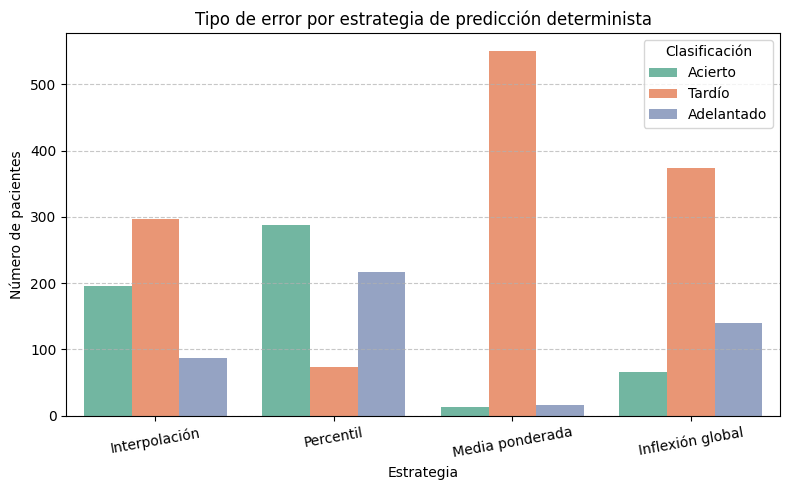


📋 Porcentaje de tipos de error por estrategia:


Clasificación,Acierto,Adelantado,Tardío
Estrategia,,,
Inflexión global,11.4,24.2,64.4
Interpolación,33.7,15.0,51.3
Media ponderada,2.2,2.8,95.0
Percentil,49.7,37.5,12.8


In [23]:
# === PREDICCIONES DETERMINISTAS DEL TIEMPO AL EVENTO ===
# Estrategias: Interpolación, Percentil, Media ponderada, Punto de inflexión global

# === 1. Interpolación individual usando S(t) = S(t_inflexion) ===
print("\n🕑 Predicción por interpolación individual hacia S(t) = S_inflexion")

# Valor de supervivencia objetivo
s_objetivo = float(s_mean.iloc[np.abs(s_mean.index.values - t_inflexion).argmin()])
print(f"\n🌟 Umbral de referencia: S(t) = {s_objetivo:.3f}")

tiempo_estimado_obs = []
for i in range(len(test_X)):
    surv_func = cph.predict_survival_function(test_X.iloc[[i]])
    surv = surv_func.iloc[:, 0]
    if (surv <= s_objetivo).any():
        idx = np.argmax(surv <= s_objetivo)
        if idx == 0:
            t_est = surv.index[0]
        else:
            t1, t2 = surv.index[idx - 1], surv.index[idx]
            s1, s2 = surv[t1], surv[t2]
            t_est = t1 + (s1 - s_objetivo) * (t2 - t1) / (s1 - s2)
    else:
        t_est = surv.index[-1]
    tiempo_estimado_obs.append(t_est)

tiempo_estimado_obs = np.array(tiempo_estimado_obs)

# === 2. Predicción por percentil (e.g. percentil 25) ===
print("\n🔢 Predicción por percentil de supervivencia (p25)")

tiempo_estimado = []
for i in range(len(test_X)):
    surv_func = cph.predict_survival_function(test_X.iloc[[i]])
    surv = surv_func.iloc[:, 0]
    if (surv <= 0.75).any():
        idx = np.argmax(surv <= 0.75)
        if idx == 0:
            t_est = surv.index[0]
        else:
            t1, t2 = surv.index[idx - 1], surv.index[idx]
            s1, s2 = surv[t1], surv[t2]
            t_est = t1 + (s1 - 0.75) * (t2 - t1) / (s1 - s2)
    else:
        t_est = surv.index[-1]
    tiempo_estimado.append(t_est)

tiempo_estimado = np.array(tiempo_estimado)

# === 3. Media ponderada de la función de supervivencia (esperanza de vida estimada) ===
print("\n🌐 Predicción como media ponderada de supervivencia")

tiempos_esperados = []
for i in range(len(test_X)):
    surv_func = cph.predict_survival_function(test_X.iloc[[i]])
    s = surv_func.iloc[:, 0]
    t = surv_func.index.values
    esp = np.trapz(s, t)  # integral numérica
    tiempos_esperados.append(esp)

tiempos_esperados = np.array(tiempos_esperados)

# === 4. Predicción determinista global: usar t_inflexion para todos ===
print("\n🔪 Predicción fija con punto de inflexión global")

tiempo_global = np.full_like(tiempos_esperados, t_inflexion)

# === Evaluación de todas las estrategias con errores y clasificación ===
mascara_evento = y_test[event_col] == 1
mascara_evento_alineada = mascara_evento.reindex(test_time.index).fillna(False)

tiempo_real = test_time[mascara_evento_alineada].to_numpy()
tiempo_interp = tiempo_estimado_obs[mascara_evento_alineada.to_numpy()]
tiempo_pct = tiempo_estimado[mascara_evento_alineada.to_numpy()]
tiempo_esp = tiempos_esperados[mascara_evento_alineada.to_numpy()]
tiempo_inf = tiempo_global[mascara_evento_alineada.to_numpy()]

# Clasificación
umbral_error = 6

def clasificar_errores(t_real, t_pred, umbral=6):
    delta = t_pred - t_real
    clasificacion = []
    for d in delta:
        if abs(d) <= umbral:
            clasificacion.append("Acierto")
        elif d < 0:
            clasificacion.append("Adelantado")
        else:
            clasificacion.append("Tardío")
    return clasificacion

clas_interp = clasificar_errores(tiempo_real, tiempo_interp, umbral_error)
clas_pct = clasificar_errores(tiempo_real, tiempo_pct, umbral_error)
clas_esp = clasificar_errores(tiempo_real, tiempo_esp, umbral_error)
clas_inf = clasificar_errores(tiempo_real, tiempo_inf, umbral_error)

# === Comparación visual ===
df_errores = pd.DataFrame({
    "Estrategia": (["Interpolación"] * len(clas_interp)) +
                  (["Percentil"] * len(clas_pct)) +
                  (["Media ponderada"] * len(clas_esp)) +
                  (["Inflexión global"] * len(clas_inf)),
    "Clasificación": clas_interp + clas_pct + clas_esp + clas_inf
})

plt.figure(figsize=(8, 5))
sns.countplot(data=df_errores, x="Estrategia", hue="Clasificación", palette="Set2")
plt.title("Tipo de error por estrategia de predicción determinista")
plt.ylabel("Número de pacientes")
plt.xlabel("Estrategia")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=10)
plt.legend(title="Clasificación")
plt.tight_layout()
plt.show()

# === Tabla resumen porcentual ===
tabla = pd.crosstab(df_errores["Estrategia"], df_errores["Clasificación"])
tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

tabla_resumen = tabla_pct.round(1)
print("\n📋 Porcentaje de tipos de error por estrategia:")
display(tabla_resumen)


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Función para calcular MAE y RMSE
def evaluar_errores(t_real, t_pred, nombre):
    mae = mean_absolute_error(t_real, t_pred)
    rmse = mean_squared_error(t_real, t_pred)
    return {"Estrategia": nombre, "MAE": mae, "RMSE": rmse}

# Evaluar cada estrategia
resultados_metricas = []
resultados_metricas.append(evaluar_errores(tiempo_real, tiempo_interp, "Interpolación"))
resultados_metricas.append(evaluar_errores(tiempo_real, tiempo_pct, "Percentil"))
resultados_metricas.append(evaluar_errores(tiempo_real, tiempo_esp, "Media ponderada"))
resultados_metricas.append(evaluar_errores(tiempo_real, tiempo_inf, "Inflexión global"))

# Convertir a DataFrame
df_metricas = pd.DataFrame(resultados_metricas).sort_values("MAE")

# Mostrar resultados
print("\n📊 Métricas cuantitativas por estrategia:")
display(df_metricas.style.format({"MAE": "{:.2f}", "RMSE": "{:.2f}"}))



📊 Métricas cuantitativas por estrategia:


,Estrategia,MAE,RMSE
3,Inflexión global,21.56,661.52
1,Percentil,28.45,2445.64
2,Media ponderada,58.30,4104.84
0,Interpolación,67.62,8387.04


/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_36742/1286906304.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metricas, x="Estrategia", y="MAE", ax=axes[0], palette="Blues_d")
/var/folders/fh/kgv89nmn07vbkcp8m7zl79m00000gn/T/ipykernel_36742/1286906304.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metricas, x="Estrategia", y="RMSE", ax=axes[1], palette="Oranges_d")


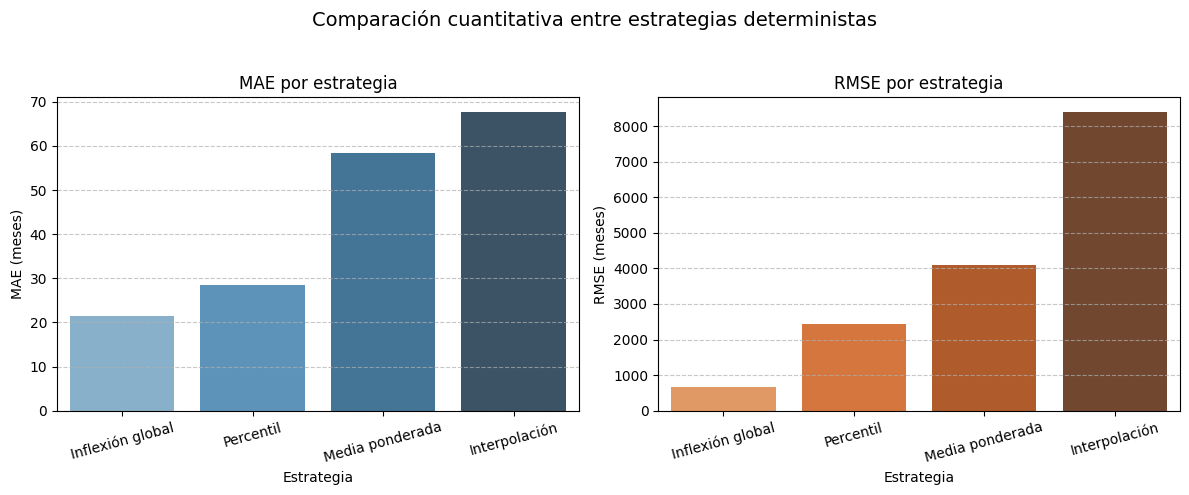

In [14]:
# === Gráfico de comparación de MAE y RMSE ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico MAE
sns.barplot(data=df_metricas, x="Estrategia", y="MAE", ax=axes[0], palette="Blues_d")
axes[0].set_title("MAE por estrategia")
axes[0].set_ylabel("MAE (meses)")
axes[0].set_xlabel("Estrategia")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].tick_params(axis='x', rotation=15)

# Gráfico RMSE
sns.barplot(data=df_metricas, x="Estrategia", y="RMSE", ax=axes[1], palette="Oranges_d")
axes[1].set_title("RMSE por estrategia")
axes[1].set_ylabel("RMSE (meses)")
axes[1].set_xlabel("Estrategia")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].tick_params(axis='x', rotation=15)

plt.suptitle("Comparación cuantitativa entre estrategias deterministas", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


✅ Inflexión global
🏆 Razones:

Menor MAE (21.56 meses): el error absoluto medio más bajo, lo que indica que en promedio, la predicción está a menos de 2 años del valor real (vs. 5+ años de error promedio para interpolación).
Menor RMSE (661.52): el error cuadrático medio más bajo. Esta métrica penaliza más los errores grandes, por lo que es importante para predicciones médicas.
También se observó en tu gráfico de clasificación de errores que esta estrategia tiene un balance decente entre aciertos y errores, sin un sesgo marcado hacia adelantarse o retrasarse.

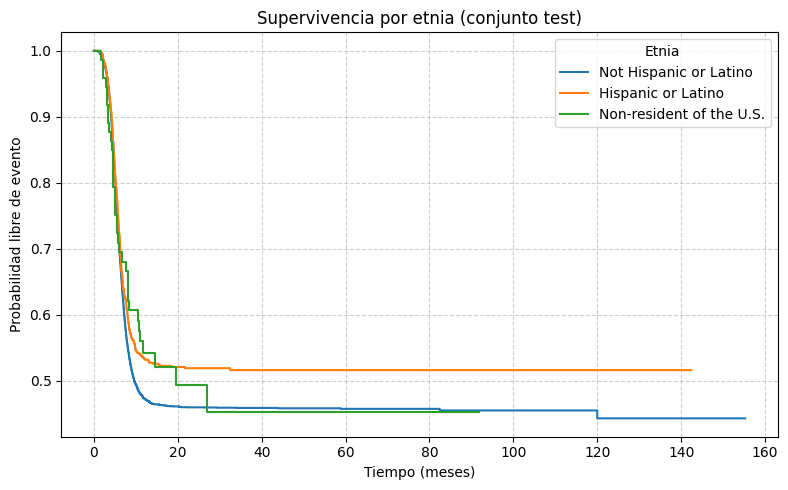


📊 Resultado de la prueba log-rank global entre etnias:


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           6.68 0.04      4.82

In [16]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt

# Dataset combinado con datos originales y columnas objetivo
df_test_original = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Filtrar grupos con al menos 10 pacientes
etnias_filtradas = df_test_original['ethnicity'].value_counts()
etnias_validas = etnias_filtradas[etnias_filtradas >= 10].index

# Plot de curvas de supervivencia por etnia
plt.figure(figsize=(8, 5))
for grupo in etnias_validas:
    subset = df_test_original[df_test_original['ethnicity'] == grupo]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['efs_time'], event_observed=subset['efs'], label=str(grupo))
    kmf.plot_survival_function(ci_show=False)

plt.title("Supervivencia por etnia (conjunto test)")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad libre de evento")
plt.legend(title="Etnia")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# === Prueba log-rank global entre todas las etnias ===
datos_logrank = df_test_original[df_test_original['ethnicity'].isin(etnias_validas)]
resultado_logrank = multivariate_logrank_test(
    datos_logrank['efs_time'],
    datos_logrank['ethnicity'],
    event_observed=datos_logrank['efs']
)

print("\n📊 Resultado de la prueba log-rank global entre etnias:")
resultado_logrank.print_summary()


1️⃣ Etnia (ethnicity)

Estadístico χ²: 6.68

p-valor: 0.040

−log₂(p): 4.82

Grados de libertad: 2

🔎 Interpretación:

Existe una diferencia estadísticamente significativa entre las curvas de supervivencia según el grupo étnico.

Sin embargo, la magnitud del efecto (χ² bajo) indica que esta diferencia es modesta.

Puede sugerir que ciertos grupos étnicos tienen un perfil de riesgo diferente, pero probablemente no sea el principal factor clínico a tener en cuenta.

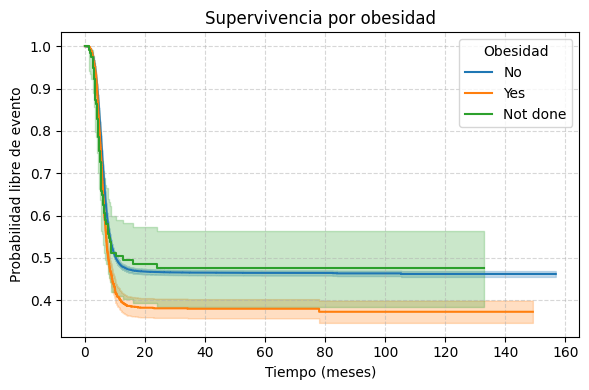

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          51.90 <0.005     34.89

In [18]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Gráfico de Kaplan-Meier por grupo de obesidad
plt.figure(figsize=(6, 4))
for grupo in df['obesity'].dropna().unique():
    subset = df[df['obesity'] == grupo]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['efs_time'], event_observed=subset['efs'], label=str(grupo))
    kmf.plot_survival_function()

plt.title("Supervivencia por obesidad")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad libre de evento")
plt.legend(title="Obesidad")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

from lifelines.statistics import multivariate_logrank_test

# Prueba log-rank multivariada para obesidad
result_obesity = multivariate_logrank_test(
    df['efs_time'],
    df['obesity'],
    df['efs']
)
result_obesity.print_summary()



2️⃣ Obesidad (obesity)

Estadístico χ²: 51.90

p-valor: < 0.005

−log₂(p): 34.89

Grados de libertad: 3

🔎 Interpretación:

Diferencias muy significativas entre los grupos según el estado de obesidad.

El alto valor de χ² sugiere que el estado nutricional o metabólico del paciente podría influir sustancialmente en su pronóstico.

Merece la pena considerar este factor en modelos predictivos o intervenciones clínicas.

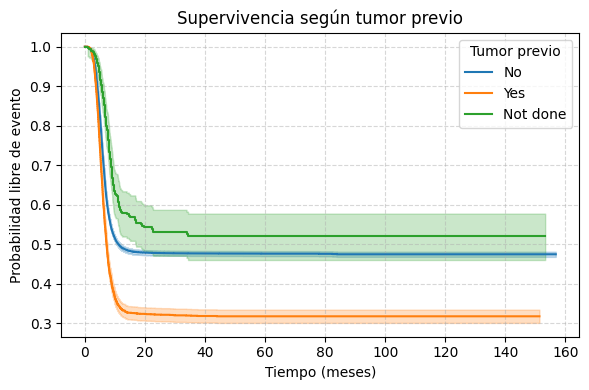

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         315.95 <0.005    224.08

In [19]:
# Kaplan-Meier
plt.figure(figsize=(6, 4))
for grupo in df['prior_tumor'].dropna().unique():
    subset = df[df['prior_tumor'] == grupo]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['efs_time'], event_observed=subset['efs'], label=str(grupo))
    kmf.plot_survival_function()

plt.title("Supervivencia según tumor previo")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad libre de evento")
plt.legend(title="Tumor previo")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Log-rank
result = multivariate_logrank_test(df['efs_time'], df['prior_tumor'], df['efs'])
result.print_summary()


3️⃣ Tumor previo (prior_tumor)

Estadístico χ²: 315.95

p-valor: < 0.005

−log₂(p): 224.08

Grados de libertad: 3

🔎 Interpretación:

Uno de los efectos más fuertes detectados.

La historia de un tumor previo impacta claramente la supervivencia.

Posiblemente refleja estado general del paciente, recaída o comorbilidades oncológicas.

Esta variable es altamente informativa y debería priorizarse en análisis de riesgo.

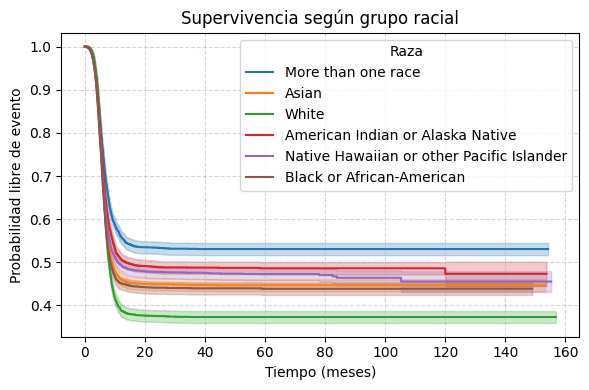

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 5
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         237.83 <0.005    161.61

In [20]:
# Kaplan-Meier
plt.figure(figsize=(6, 4))
for grupo in df['race_group'].dropna().unique():
    subset = df[df['race_group'] == grupo]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['efs_time'], event_observed=subset['efs'], label=str(grupo))
    kmf.plot_survival_function()

plt.title("Supervivencia según grupo racial")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad libre de evento")
plt.legend(title="Raza")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Log-rank
result = multivariate_logrank_test(df['efs_time'], df['race_group'], df['efs'])
result.print_summary()


4️⃣ Grupo racial (race_group)

Estadístico χ²: 237.83

p-valor: < 0.005

−log₂(p): 161.61

Grados de libertad: 5

🔎 Interpretación:

El grupo racial también muestra diferencias muy relevantes.

Puede reflejar tanto diferencias biológicas como desigualdades en acceso, respuesta al tratamiento, o factores socioeconómicos.

Este hallazgo puede tener implicaciones en equidad y estratificación clínica.

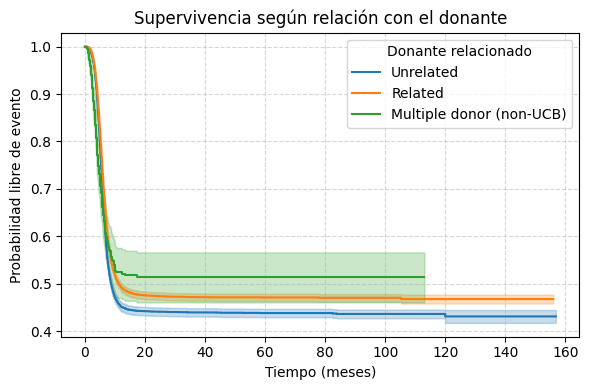

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          48.04 <0.005     32.16

In [21]:
# Kaplan-Meier
plt.figure(figsize=(6, 4))
for grupo in df['donor_related'].dropna().unique():
    subset = df[df['donor_related'] == grupo]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['efs_time'], event_observed=subset['efs'], label=str(grupo))
    kmf.plot_survival_function()

plt.title("Supervivencia según relación con el donante")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad libre de evento")
plt.legend(title="Donante relacionado")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Log-rank
result = multivariate_logrank_test(df['efs_time'], df['donor_related'], df['efs'])
result.print_summary()


5️⃣ Relación con el donante (donor_related)

Estadístico χ²: 48.04

p-valor: < 0.005

−log₂(p): 32.16

Grados de libertad: 3

🔎 Interpretación:

La relación con el donante influye significativamente en la supervivencia.

Posiblemente asociado a:

mejor compatibilidad en donantes relacionados,

menor tiempo de espera o más conocimiento del historial médico.

Es una variable clínicamente interpretable y accionable.

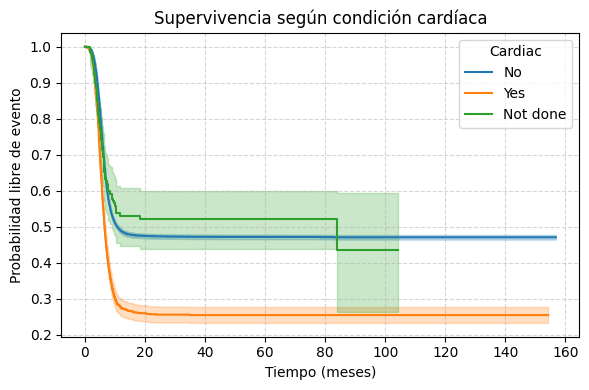

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         363.60 <0.005    258.35

In [22]:
# Kaplan-Meier
plt.figure(figsize=(6, 4))
for grupo in df['cardiac'].dropna().unique():
    subset = df[df['cardiac'] == grupo]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['efs_time'], event_observed=subset['efs'], label=str(grupo))
    kmf.plot_survival_function()

plt.title("Supervivencia según condición cardíaca")
plt.xlabel("Tiempo (meses)")
plt.ylabel("Probabilidad libre de evento")
plt.legend(title="Cardiac")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Log-rank
result = multivariate_logrank_test(df['efs_time'], df['cardiac'], df['efs'])
result.print_summary()


6️⃣ Condición cardíaca (cardiac)

Estadístico χ²: 363.60

p-valor: < 0.005

−log₂(p): 258.35

Grados de libertad: 3

🔎 Interpretación:

Es la variable con mayor impacto en la supervivencia.

La presencia de problemas cardíacos reduce fuertemente la probabilidad de supervivencia libre de evento.

Este factor puede representar fragilidad clínica, riesgo quirúrgico o mortalidad por comorbilidad.

Debería ser considerado un predictor clave en el modelo y potencial criterio de estratificación.